# The Tolman–Oppenheimer–Volkoff equations (Lindblom's form)

We study the log-entalpy formulation of the Oppenheimer–Volkoff equations (also known as Lindblom's form). This formulation (here taken from [Martin Jakob Steil's thesis](https://theorie.ikp.physik.tu-darmstadt.de/nhq/downloads/thesis/master.steil.pdf) in Section 3.2.3) 
has several advantages w.r.t. the original formulation by Tolman–Oppenheimer–Volkoff:

* It directly describes the radius and mass of the star.
* It has a known integration domain.
* It is not stiff.

In this formulation, the state is:

$$
\mathbf x=[r^2, m/r]=[x_0, x_1]
$$,

and the parameters are:

$$
\mathbf p = [\eta_K, \eta_\Gamma]
$$,

 where $K = \overline K(1+\eta_K)$ and $\Gamma = \overline \Gamma(1+\eta_\Gamma)$ will parameterize the equation of state of a polytrope (a gaseous sphere in hydrodynamic equilibrium).

The equations are then written as:

$$\Large
\left\{
\begin{array}{ll}
\frac{dx_0}{dh} &= -\frac{2x_0 (1-2x_1)}{4\pi x_0 P(h) + x_1}\\
\frac{dx_1}{dh} &= \left(2\pi \epsilon(h) - \frac{x_1}{2x_0}\right) \frac{dx_0}{dh} \\
\end{array}\right.
$$

where an equation of state is needed to define the pressure $P(h)$ and energy density $\epsilon(h)$ expressions. 

In the case of a relativistic polytrope here studied, the log-entalpy is introduced and defined as:

$$
h = \log{[(\epsilon+P) / \rho]}
$$

where $\rho$ is the (baryonic) mass density (following a [polytropic process](https://en.wikipedia.org/wiki/Polytropic_process)):

$$\Large
\begin{array}{l}
\rho = (\frac{P}{K})^{1/\Gamma} \\
\epsilon = \rho + P / (\Gamma-1)
\end{array}
$$

Hence, in this case the log-entalpy can be written as:
$$
h = \log\left(1 + \frac{\Gamma}{\Gamma-1} K^{\frac 1\Gamma} P^{1-\frac 1\Gamma}\right)
$$

which can be inverted to yield the $P(h)$ form:
$$
P(h) = K^{-\frac{1}{\Gamma-1}}\left[\frac{\Gamma-1}{\Gamma}\left(e^h-1\right)\right]^{\frac{\Gamma}{\Gamma-1}}
$$


**Note**: the dynamics is singular at $h=0$ (of a removable kind), so we will need to define the initial conditions at some small $\delta h$ where the singularity is not present.


In [17]:
import heyoka as hy
import numpy as np
from scipy import optimize
from copy import deepcopy

import time

import matplotlib.pyplot as plt

# 0 - Preamble 
Let us start introducing common definitions and the reference numerical values we will be using for the parameters $K, \Gamma$ of the polytrope.

In [18]:
# State variables
x0, x1 = hy.make_vars("x0", "x1")

# The independent variable is log-enthalpy not time, thus we rename it as follows:
h = hy.time

# Parameters values
Gamma_v = 2.0
K_v = 100.0

# Parameters expressions
Gamma = Gamma_v * (1.0 + hy.par[0])
K = K_v * (1.0 + hy.par[1])

# Other expressions
P = hy.exp(hy.log(K) * (-1.0 / (Gamma - 1.0))) * hy.exp(
    hy.log((Gamma - 1.0) / Gamma * (hy.exp(h) - 1.0)) * (Gamma / (Gamma - 1.0))
)
rho = hy.exp(hy.log(P / K) / Gamma)
eps = rho + P / (Gamma - 1.0)

# The dynamics
dx0dh = -2.0 * x0 * (1.0 - 2.0 * x1) / (4.0 * np.pi * x0 * P + x1)
dyn = [
    (x0, dx0dh),
    (x1, (2.0 * np.pi * eps - x1 / 2.0 / x0) * dx0dh),
]

# 1 - Standard Numerical Solution
The Tolman–Oppenheimer–Volkoff equations in the Lindblom form are numerically well behaved. 

We here show a straight forward numerical integration using the Taylor adaptive scheme of *heyoka*.

In [19]:
# We instantiate the numerical ODE solver
ta = hy.taylor_adaptive(dyn, state=[1.0, 1.0], time=0.1, tol=1e-16)

We define the conditions at the star center fixing the pressure $P_c$, and thus computing the corresponding density $\rho_c$, energy density $\epsilon_c$ and log-entalpy $h_c$

In [117]:
# Pressure (Change this value to then approximate different part of the M-R curve)
P_c = 1.6387261275696853e-2

# Density
rho_c = (P_c / K_v) ** (1.0 / Gamma_v)

# Energy density
eps_c = rho_c + P_c / (Gamma_v - 1.0)

# log-entalpy
h_c = np.log(
    1 + Gamma_v / (Gamma_v - 1) * K_v ** (1 / Gamma_v) * P_c ** (1.0 - 1.0 / Gamma_v)
)

print("Conditions at the star center:")
print("\nPressure: ", P_c)
print("Energy density: ", eps_c)
print("Density: ", rho_c)
print("log-entalpy: ", h_c)

Conditions at the star center:

Pressure:  0.016387261275696854
Energy density:  0.029188535148127227
Density:  0.012801273872430375
log-entalpy:  1.2698321081700996


From the conditions at the star center (c) we derive the initial conditions (0) for the numerical integration offsetting the entalpy (the independent variable) by a small amount, thus avoiding the numerical (removable) singularity in the dynamics:

In [118]:
# Since the dynamics is singular at h_c, we define the initial conditions at h_0 = h_c - dh
dh = 1e-6 # note that if this gets too small the variational equations may have numerical issues at h_0.
h_0 = h_c-dh

# Initial conditions at h_0 (from Steil thesis). Could be improved at second order.
x0_0 = 3.0 / (2.0 * np.pi * (3.0 * P_c + eps_c)) * dh
x1_0 = 2.0 * eps_c / (3*P_c+eps_c) * dh
y_0 = [x0_0, x1_0]

We are now ready to perform a numerical integration, and extract from the result the star radius and mass:

In [119]:
start = time.time()
ta.time = h_0
ta.state[:] = y_0
ta.pars[:] = [0., 0.]
time_grid = np.linspace(h_0, 0., 100) 
sol = ta.propagate_grid(time_grid)
time_cost = time.time() - start
print("Total time to propagate:", time_cost)
print("Outcome (should be time_limit if all went well): ", str(sol[0]).split(".")[1])

# The mass and radius are easily computed from the last value reached
rf = np.sqrt(sol[-1][:,0][-1])
Mf = sol[-1][:,1][-1] * rf

print("Final value for the stellar radius is: ", rf)
print("Final value for the stellar mass is: ", Mf)

Total time to propagate: 0.0006039142608642578
Outcome (should be time_limit if all went well):  time_limit
Final value for the stellar radius is:  5.219851302416713
Final value for the stellar mass is:  1.2800001679264132


we now plot the results of the numerical integration.

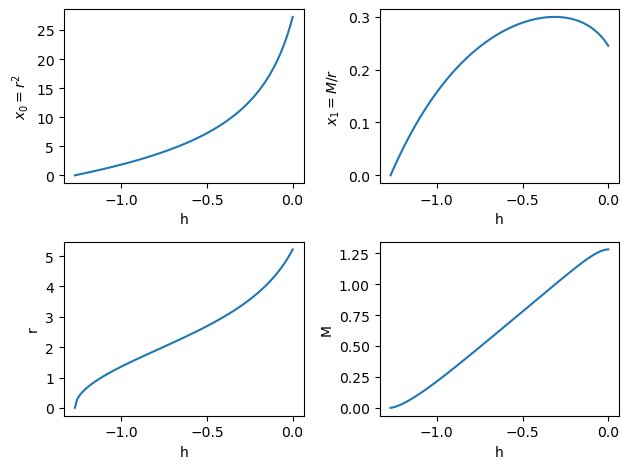

In [120]:
r2_plot = sol[-1][:,0]
mr_plot = sol[-1][:,1]

# Plots
ax = plt.subplot(2,2,1)
ax.plot(-time_grid, r2_plot)
ax.set_xlabel("h")
ax.set_ylabel("$x_0 = r^2$")

ax = plt.subplot(2,2,2)
ax.plot(-time_grid, mr_plot)
ax.set_xlabel("h")
ax.set_ylabel("$x_1 = M / r$")

ax = plt.subplot(2,2,3)
ax.plot(-time_grid, np.sqrt(r2_plot))
ax.set_xlabel("h")
ax.set_ylabel("r")

ax = plt.subplot(2,2,4)
ax.plot(-time_grid, mr_plot*np.sqrt(r2_plot))
ax.set_xlabel("h")
ax.set_ylabel("M")
plt.tight_layout()


# 2 - Variational equations
We seek an analytical expression for the stellar mass and radius, as a function of the variation of the conditions at the stellar center $\delta h_c$. 

In order to obtain the expressions seeked, a variational equation for the initial value of the entalpy (the independent variable) $h_0$ is also needed. We thus introduce a last variable change $\overline h_0 s = h$ so that the differential equations become:

$$\Large
\left\{
\begin{array}{ll}
\frac{dx_0}{ds} &= - \overline h_0 \frac{2x_0 (1-2x_1)}{4\pi x_0 P(s) + x_1}\\
\frac{dx_1}{ds} &= \left(2\pi \epsilon(s) - \frac{x_1}{2x_0}\right) \frac{dx_0}{ds} \\
\end{array}\right.
$$

with:
$$
P(s) = K^{-\frac{1}{\Gamma-1}}\left[\frac{\Gamma-1}{\Gamma}\left(e^{\overline h_0 s}-1\right)\right]^{\frac{\Gamma}{\Gamma-1}}
$$

and:
$$\Large
\begin{array}{l}
\rho(s) = \left(\frac{P(s)}{K}\right)^{1/\Gamma} \\
\epsilon(s) = \rho + P(s) / (\Gamma-1)
\end{array}
$$
and must be integrated for $s \in [1, 0]$, which will correspond to $h \in [\overline h_0, 0]$

In [121]:
# The independent variable is s, not h = log(entalpy) nor t.
s = hy.time

# Important expressions
P = hy.exp(hy.log(K) * (-1.0 / (Gamma - 1.0))) * hy.exp(
    hy.log((Gamma - 1.0) / Gamma * (hy.exp(h) - 1.0)) * (Gamma / (Gamma - 1.0))
)
rho = hy.exp(hy.log(P / K) / Gamma)
eps = rho + P / (Gamma - 1.0)

# Important expressions
P = hy.exp(hy.log(K) * (-1.0 / (Gamma - 1.0))) * hy.exp(
    hy.log((Gamma - 1.0) / Gamma * (hy.exp( hy.par[2]*s) - 1.0)) * (Gamma / (Gamma - 1.0))
)
rho = hy.exp(hy.log(P / K) / Gamma)
eps = rho + P / (Gamma - 1.0)

# We define the dynamics
dx0ds = (-2.0 * x0 * (1.0 - 2.0 * x1) / (4.0 * np.pi * x0 * P + x1)) * hy.par[2]
dyn2 = [
    (x0, dx0ds),
    (x1, (2.0 * np.pi * eps - x1 / 2.0 / x0) * dx0ds),
]

In [122]:
# We augment the dynamics with the variational equations
var_sys = hy.var_ode_sys(dyn2, args=[x0, x1, hy.par[2]], order=6)

# We instantiate the Taylor adaptive integrator for the system of equations augmented with the variational ones
ta_var = hy.taylor_adaptive(
    var_sys,
    state=[1.0, 1.0],
    time=0.1,
    tol=1e-18,
    compact_mode=True,
)
# We copy, for future reference, the initial conditions on the variational state
ic_var = list(deepcopy(ta_var.state[2:]))

In [123]:
start = time.time()
ta_var.time = 1.

ta_var.state[:] = y_0 + ic_var
ta_var.pars[:] = [0., 0., h_0]

s_grid = np.linspace(1.,0., 100)
sol_var = ta_var.propagate_grid(s_grid)
print("Total time to propagate:", time.time() - start)
print("Outcome: ", sol_var[0])

rf = np.sqrt(sol_var[-1][:,0][-1])
Mf = sol_var[-1][:,1][-1] * rf

print("Final value for the stellar radius is: ", rf)
print("Final value for the stellar mass is: ", Mf)

Total time to propagate: 0.8472447395324707
Outcome:  taylor_outcome.time_limit
Final value for the stellar radius is:  5.219851302416711
Final value for the stellar mass is:  1.2800001679264128


We have thus computed the following polynomial approximations (degree $k$):

$$
\begin{array}{l}
R_{\odot} = \mathcal P^k_R(\delta x_{0_0}, \delta x_{1_0},\delta h_0) \\
M_{\odot} = \mathcal P^k_M(\delta x_{0_0}, \delta x_{1_0}, \delta h_0) 
\end{array}
$$

Note the underscript $0$ refers to the initial values, not to the star center which would here be indicated using $c$ rather than $0$.

In [124]:
# We repeat the computation changing the pressure at the center.

# Pressure
P_c_new = P_c*(1.+3.)

# Density
rho_c_new = (P_c_new / K_v) ** (1.0 / Gamma_v)

# Energy density
eps_c_new = rho_c_new + P_c_new / (Gamma_v - 1.0)

# log-entalpy
h_c_new = np.log(
    1 + Gamma_v / (Gamma_v - 1) * K_v ** (1 / Gamma_v) * P_c_new ** (1.0 - 1.0 / Gamma_v)
)

print("Conditions at the star center:")
print("\nPressure: ", P_c_new)
print("Energy density: ", eps_c_new)
print("Density: ", rho_c_new)
print("log-entalpy: ", h_c_new)

Conditions at the star center:

Pressure:  0.06554904510278742
Energy density:  0.09115159284764816
Density:  0.02560254774486075
log-entalpy:  1.8116453526943157


We may now find the new starting conditions at $h_c-dh$.

In [125]:
h_0_new = h_c_new-dh

# Initial conditions at h_0_new (from Steil thesis). Can be improved at second order.
x0_0_new = 3.0 / (2.0 * np.pi * (3.0 * P_c_new + eps_c_new)) * dh
x1_0_new = 2.0 * eps_c_new / (3*P_c_new+eps_c_new) * dh
y_0_new = [x0_0_new, x1_0_new]

We can now use the Taylor approximation to compute the stellar radius and mass:


In [126]:
taylor_approx = ta_var.eval_taylor_map([x0_0_new-x0_0, x1_0_new-x1_0, h_0_new-h_0])
rf_new_taylor = np.sqrt(taylor_approx[0])
Mf_new_taylor = taylor_approx[1] * rf_new_taylor

print("Final value for the stellar radius is: ", rf_new_taylor)
print("Final value for the stellar mass is: ", Mf_new_taylor)

Final value for the stellar radius is:  4.8522483797224085
Final value for the stellar mass is:  1.0752127214501672


We now compute these values by numerical integration.

In [127]:
start = time.time()
ta.time = h_0_new
ta.state[:] = y_0_new
ta.pars[:] = [0., 0.]
time_grid = np.linspace(h_0_new, 0., 100) 
sol_new = ta.propagate_grid(time_grid)
time_cost = time.time() - start
print("Total time to propagate:", time_cost)
print("Outcome (should be time_limit if all went well): ", str(sol_new[0]).split(".")[1])

# The mass and radius are easily computed from the last value reached
rf_new = np.sqrt(sol_new[-1][:,0][-1])
Mf_new = sol_new[-1][:,1][-1] * rf_new

print("Final value for the stellar radius is: ", rf_new)
print("Final value for the stellar mass is: ", Mf_new)

Total time to propagate: 0.00084686279296875
Outcome (should be time_limit if all went well):  time_limit
Final value for the stellar radius is:  4.850735249973897
Final value for the stellar mass is:  1.0749873071329459


Lets see the error introduced by the Taylor approximation:

In [128]:
print("Absolute error on mass:", Mf_new-Mf_new_taylor)
print("Absolute error on radius:", rf_new-rf_new_taylor)

print("\nRelative error on mass:", (Mf_new-Mf_new_taylor) / Mf_new)
print("Relative error on radius:", (rf_new-rf_new_taylor) / rf_new)

Absolute error on mass: -0.00022541431722133964
Absolute error on radius: -0.001513129748511588

Relative error on mass: -0.00020969021282914757
Relative error on radius: -0.00031193822596682234


# The $M_\odot$ vs $R_\odot$ plot

We now loop over different star conditions (at the core) and plot the relation between mass and radius using the Taylor approximation and the numerical integrator.

In [129]:
start = time.time()
Rstar=[]
Mstar = []
P_grid = np.linspace(P_c*(1.-0.95), P_c*(1+10.),1000)
for P_c_new in P_grid:
    # Density
    rho_c_new = (P_c_new / K_v) ** (1.0 / Gamma_v)

    # Energy density
    eps_c_new = rho_c_new + P_c_new / (Gamma_v - 1.0)

    # log-entalpy
    h_c_new = np.log(
        1 + Gamma_v / (Gamma_v - 1) * K_v ** (1 / Gamma_v) * P_c_new ** (1.0 - 1.0 / Gamma_v)
    )

    # Since the dynamics is singular at h_c, we define the initial conditions at h_0 = h_c - dh
    h_0_new = h_c_new-dh

    # Initial conditions at h_0 (from Steil thesis). Can be improved at second order.
    x0_0_new = 3.0 / (2.0 * np.pi * (3.0 * P_c_new + eps_c_new)) * dh
    x1_0_new = 2.0 * eps_c_new / (3*P_c_new+eps_c_new) * dh
    taylor_approx = ta_var.eval_taylor_map([x0_0_new-x0_0, x1_0_new-x1_0, h_0_new-h_0])
    Rstar.append(np.sqrt(taylor_approx[0]))
    Mstar.append(taylor_approx[1]*np.sqrt(taylor_approx[0]))
time_cost = time.time() - start
print("Total computation time using the Taylor Map:", time_cost)

Total computation time using the Taylor Map: 0.008171796798706055


In [130]:
start = time.time()
Rstar_gt=[]
Mstar_gt = []
P_grid = P_c * np.logspace(0.01, 12,1000) / 10.
for P_c_new in P_grid:
    # Density
    rho_c_new = (P_c_new / K_v) ** (1.0 / Gamma_v)

    # Energy density
    eps_c_new = rho_c_new + P_c_new / (Gamma_v - 1.0)

    # log-entalpy
    h_c_new = np.log(
        1 + Gamma_v / (Gamma_v - 1) * K_v ** (1 / Gamma_v) * P_c_new ** (1.0 - 1.0 / Gamma_v)
    )

    # Since the dynamics is singular at h_c, we define the initial conditions at h_0 = h_c - dh
    h_0_new = h_c_new-dh

    # Since the dynamics is singular at h_c, we define the initial conditions at h_0 = h_c - dh
    h_0_new = h_c_new-dh

    # Initial conditions at h_0 (from Steil thesis). Can be improved at second order.
    x0_0_new = 3.0 / (2.0 * np.pi * (3.0 * P_c_new + eps_c_new)) * dh
    x1_0_new = 2.0 * eps_c_new / (3*P_c_new+eps_c_new) * dh

    ta.time = h_0_new
    ta.state[:] = y_0_new
    outcome = ta.propagate_until(0.)

    # The mass and radius are easily computed from the last value reached    
    Rstar_gt.append(np.sqrt(ta.state[0]))
    Mstar_gt.append(ta.state[1]*np.sqrt(ta.state[0]))
time_cost = time.time() - start
print("Total time using the numerical integrator:", time_cost)

Total time using the numerical integrator: 0.08371686935424805


And lets have a look at the difference in the computed values for this range:

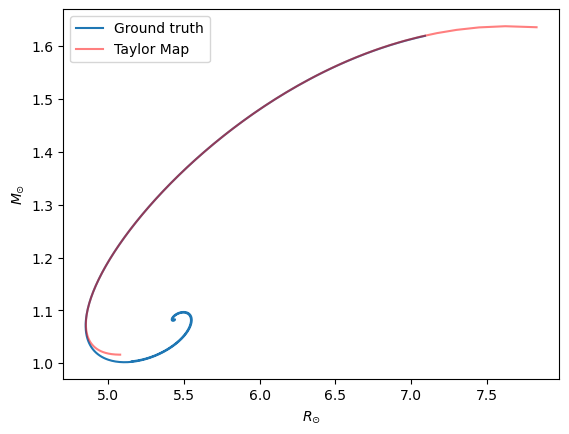

In [131]:
plt.plot(Rstar_gt, Mstar_gt, label = "Ground truth")
plt.plot(Rstar, Mstar, c='r', alpha=0.5, label = "Taylor Map")

plt.xlabel("$R_{\odot}$")
plt.ylabel("$M_{\odot}$")
plt.legend()

**Conclusions**: 
* the use of the high order variational equations to solve the Tolman–Oppenheimer–Volkoff equations result in a relatively large convergence radius (when using the Lindblom form) of the resulting Taylkor map.
* the resulting speedup in the evaluation of the mass/radius curve seems to be of the order of one order of magnitude.
* the Taylor map allows to capture well the maximum allowed stellar mass.

We are not sure this is useful, but damn its cool!